Churn EDA

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(123)
df = pd.read_csv('../data/raw/train.csv')
df.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Customer Status,Last Due Date,Last Payment Date,Churn
0,160831,34,Male,NaN,26,none,17.0,Basic,Quarterly,890.21,30.0,active,06-21,07-08,0
1,354435,30,Male,36.0,22,NaN,15.0,Basic,Annual,954.37,30.0,active,06-10,06-25,0
2,444576,23,Male,44.0,14,none,NaN,Premium,Annual,674.00,21.0,inactive,06-27,07-21,1
3,130847,24,Male,39.0,21,2,14.0,Standard,Quarterly,775.00,18.0,active,06-30,07-14,0
4,108121,26,Male,NaN,26,1,5.0,Basic,Quarterly,679.45,NaN,active,06-29,07-04,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303124 entries, 0 to 303123
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         303124 non-null  int64  
 1   Age                303124 non-null  int64  
 2   Gender             303124 non-null  object 
 3   Tenure             241103 non-null  float64
 4   Usage Frequency    303124 non-null  int64  
 5   Support Calls      240704 non-null  object 
 6   Payment Delay      214800 non-null  float64
 7   Subscription Type  303124 non-null  object 
 8   Contract Length    303124 non-null  object 
 9   Total Spend        303124 non-null  float64
 10  Last Interaction   240574 non-null  float64
 11  Customer Status    303124 non-null  object 
 12  Last Due Date      303124 non-null  object 
 13  Last Payment Date  303124 non-null  object 
 14  Churn              303124 non-null  int64  
dtypes: float64(4), int64(4), object(7)
memory usage: 34

In [4]:
df.isna().sum()

CustomerID               0
Age                      0
Gender                   0
Tenure               62021
Usage Frequency          0
Support Calls        62420
Payment Delay        88324
Subscription Type        0
Contract Length          0
Total Spend              0
Last Interaction     62550
Customer Status          0
Last Due Date            0
Last Payment Date        0
Churn                    0
dtype: int64

<Axes: xlabel='Usage Frequency', ylabel='Count'>

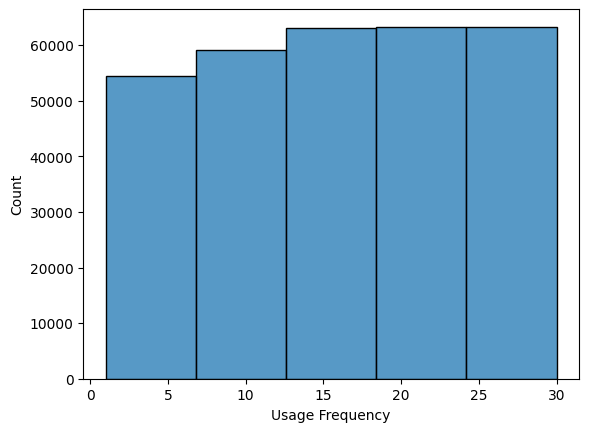

In [5]:
import seaborn as sns
sns.histplot(data=df,x='Usage Frequency',bins=5)

In [6]:
def clean_numeric(df,column,assume):
    df[column] = df[column].fillna(assume)
    df[column] = df[column].replace('none', assume)
    df[column] = df[column].astype('int64')

clean_numeric(df,'Support Calls',0)
df['Support Calls'].value_counts()

Support Calls
0     107561
1      44823
2      42581
3      31887
4      20833
5       9952
9       9175
10      9112
7       9110
6       9061
8       9029
Name: count, dtype: int64

In [7]:
test = pd.read_csv('../data/raw/test.csv')
clean_numeric(test,'Support Calls',0)
submission = pd.DataFrame(test['CustomerID'])
submission['Churn'] = submission['CustomerID'].apply(lambda x: 1 if random.random() >= .7 else 0)
submission.to_csv('../data/submission/proportion_guess.csv',index=False)
submission['Churn'].value_counts()/len(submission)


Churn
0    0.698496
1    0.301504
Name: count, dtype: float64

In [8]:
df['Gender'].value_counts()

Gender
Male      181216
Female    121908
Name: count, dtype: int64

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_cols = ['Usage Frequency', 'Support Calls','Age']
X = df[X_cols]
y = df['Churn']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, stratify=y, random_state=30)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test = test[X_cols]
X_test_scaled = scaler.fit_transform(test[X_cols])

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled,y_train)
val_pred = knn.predict_proba(X_val_scaled)[:,1]
test_pred = knn.predict_proba(X_test_scaled)[:,1]

print(f'validation auc: {roc_auc_score(y_val, val_pred)}')



validation auc: 0.8082149454352168


In [10]:
submission['Churn'] = test_pred
submission.to_csv('../data/submission/knn_simple.csv',index=False)

In [28]:
from sklearn.tree import DecisionTreeClassifier
for i in range(1,12):
    X_cols = ['Age','Tenure','Usage Frequency','Support Calls','Payment Delay','Total Spend','Last Interaction']
    X = df[X_cols]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, stratify=y, random_state=30)
    X_test = test[X_cols]
    tree = DecisionTreeClassifier(max_depth=i,random_state=9)
    tree.fit(X_train, y_train)
    val_pred = tree.predict_proba(X_val)[:,1]
    print(f'validation auc: {roc_auc_score(y_val, val_pred)} i={i}')
    test_pred_tree = tree.predict_proba(X_test)[:,1]
submission['Churn'] = test_pred
submission.to_csv('../data/submission/decision_tree.csv',index=False)

validation auc: 0.9863274806641985 i=1
validation auc: 0.9993719709295461 i=2
validation auc: 0.9996252211076182 i=3
validation auc: 0.9997601122222118 i=4
validation auc: 0.9998224914918484 i=5
validation auc: 0.9998408002633994 i=6
validation auc: 0.9998008460790511 i=7
validation auc: 0.9994877805100462 i=8
validation auc: 0.9992283306688488 i=9
validation auc: 0.9987519588385995 i=10
validation auc: 0.9983864824640081 i=11


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303124 entries, 0 to 303123
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         303124 non-null  int64  
 1   Age                303124 non-null  int64  
 2   Gender             303124 non-null  object 
 3   Tenure             241103 non-null  float64
 4   Usage Frequency    303124 non-null  int64  
 5   Support Calls      303124 non-null  int64  
 6   Payment Delay      214800 non-null  float64
 7   Subscription Type  303124 non-null  object 
 8   Contract Length    303124 non-null  object 
 9   Total Spend        303124 non-null  float64
 10  Last Interaction   240574 non-null  float64
 11  Customer Status    303124 non-null  object 
 12  Last Due Date      303124 non-null  object 
 13  Last Payment Date  303124 non-null  object 
 14  Churn              303124 non-null  int64  
dtypes: float64(4), int64(5), object(6)
memory usage: 34